In [14]:
import tensorflow as tf
# import sklearn
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import shutil

import keras


# from keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow.compat'

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
#Definição dos caminhos de treino, teste e validaca

main_path = pathlib.Path(r"./GroceryStoreDataset/dataset")

path_train = os.path.join(main_path,"train")
path_test = os.path.join(main_path,"test")
path_val = os.path.join(main_path,"val")


In [ ]:
#Diretorio de metadados das classes
classes = pd.read_csv(os.path.join(main_path, "classes.csv"))

In [ ]:
# Metadados de treino, teste e validacao
train_fl = pd.read_csv(os.path.join(main_path, "train.txt"), header=None, names=["path", "classId", "coarseClassId"])
test_fl = pd.read_csv(os.path.join(main_path, "test.txt"), header=None, names=["path", "classId", "coarseClassId"])
val_fl = pd.read_csv(os.path.join(main_path, "val.txt"), header=None, names=["path", "classId", "coarseClassId"])

# Pré processamento de diretórios

In [4]:
# Remoção de subniveis dos diretórios (parse de classes granulares, como tipo de frutas)

# level = 0
# def verifyDir(dir, last_dir= None, level=0):
#     subdir = os.listdir(dir)
#     level += 1
#     for file in subdir:
#         subpath = os.path.join(dir, file)
#         if os.path.isdir(subpath):
#             verifyDir(subpath, dir, level)
#         else:

#             if level == 4:
#                 shutil.move(subpath, os.path.join(last_dir, file))
#                 if len(os.listdir(dir)) == 0:
#                     shutil.rmtree(dir)

# for path in [path_train, path_test, path_val]:
#     verifyDir(path, None)

In [ ]:
# Organização dos subdiretorios das classes e eliminação das classes primarias (frutas, pacotes e vegetais)

# col = ["Fruit", "Packages", "Vegetables"]
# for path in [path_train, path_test, path_val]:
#     for c in col:
#         caminho = os.path.join(path, c)
#         print(caminho)
#         for dir in os.listdir(caminho):
#             print(os.path.join(caminho, dir),  len(os.listdir(os.path.join(caminho))))
#             shutil.move(os.path.join(caminho, dir), path)
#             # if len(os.listdir(caminho)) == 1:
#             #     shutil.rmtree(caminho)

# for path in [path_train, path_test, path_val]:
#     for c in col:
#         shutil.rmtree(os.path.join(path, c))

In [35]:
# Olhar intersecção de classes, para identificar classes que estão no treino, porém não estão no conjunto de teste ou validação (e vice versa)

# dc = {}
# for path in [path_train, path_test, path_val]:
#   a = []
#   for file in os.listdir(path):
#     a.append(file)
#     dc[path.split("/")[-1]] = set(a)

# intersect = dc["train"].intersection(dc["test"], dc["val"])

In [44]:
# Remoção das classes restantes (que estão somente no treino, ou somente no teste)

# for path in [path_train, path_test, path_val]:
#   for file in os.listdir(path):
#     if file not in intersect:
#       print(os.path.join(path, file))
#       shutil.rmtree(os.path.join(path, file))

drive/MyDrive/Inteligencia_Artificial_2023/GroceryStoreDataset-master/dataset/train/Brown-Cap-Mushroom
drive/MyDrive/Inteligencia_Artificial_2023/GroceryStoreDataset-master/dataset/val/Brown-Cap-Mushroom


# Leitura das bases pré processadas

In [12]:
train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(348,348),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test = tf.keras.utils.image_dataset_from_directory(
    path_test,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(348,348),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(348,348),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

AttributeError: module 'tensorflow' has no attribute 'keras'

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Otimização de performance, para utilizar um buffer do dataset em memória

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 348

# Pré processamento : Resize de imagens e ajustar escala
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

# Pré processamento : Data Augmentation (rotação aleatoria de imagens, para prevenir overfitting)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Função para filtrar dataset conforme classes específicadas

def filter_dataset(i, l):
    label_indices_to_delete = tf.constant([8, 10, 15, 24, 26, 33], dtype=tf.int64)
    labels = tf.argmax(l)  # Assuming your labels are stored in an attribute called 'labels'

    # Get the boolean mask for elements to keep
    mask = tf.math.logical_not(tf.reduce_any(tf.math.equal(labels, label_indices_to_delete[:, None]), axis=0))

    return tf.reduce_all(mask)

# Função principal para preparar dataset, limpar, pré processar e reintegrar.

def prepare(ds, shuffle=False, augment=False, filter=False):

  if filter:
    ds = ds.filter(filter_dataset)

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # Shuffle dataset.
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)



In [9]:
train_ds = prepare(train.unbatch(), shuffle=False, augment=True, filter=False)
val_ds = prepare(val.unbatch())
test_ds = prepare(test.unbatch(), filter=False)

In [23]:
labels = [np.argmax(y) for x, y in train_ds.unbatch()]

lb = pd.DataFrame(labels)

# Contagem de labels do dataset de treino, após modificações
lb.value_counts().sort_index()

KeyboardInterrupt: ignored

AttributeError: ignored

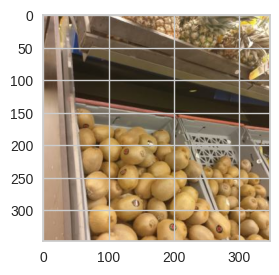

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # print(labels[i])
    plt.title(train.class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
# import tensorflow as tf

# # Assuming train_dataset and test_dataset are your original datasets
# # with 43 classes

# classes_to_remove = tf.constant([8, 10, 15, 24, 26, 33], dtype=tf.int64)

# def filter_classes(features, labels):
#     # labels are one-hot encoded
#     # Convert one-hot encoded labels to class indices
#     class_indices = tf.argmax(labels, axis=-1)
#     # Check if the class index is in classes_to_remove
#     condition = tf.math.equal(class_indices[:, None], classes_to_remove)
#     # Return a scalar boolean tensor
#     return tf.math.logical_not(condition)

# # Use the filter method to create new filtered datasets
# filtered_train_dataset = train.filter(filter_classes)
# filtered_test_dataset = test.filter(filter_classes)


# Treino do modelo

In [10]:

vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(348,348,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(348,348,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inception = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(348,348,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)



In [11]:
def create_model(model) -> Sequential:
  m = Sequential()
  m.add(model)
  m.add(layers.Flatten())
  # m.add(layers.Dense(72, activation='relu'))
  m.add(layers.Dropout(0.5))
  m.add(layers.Dense(36, activation='softmax'))
  return m

In [15]:
model = create_model(inception)

In [16]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 124416)            0         
                                                                 
 dropout_1 (Dropout)         (None, 124416)            0         
                                                                 
 dense_1 (Dense)             (None, 36)                4479012   
                                                                 
Total params: 58815748 (224.36 MB)
Trainable params: 58755204 (224.13 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________
None


In [17]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, ds_train, ds_val, n_epochs=20, n_batch=32, lr=1e-4):
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(ds_train, epochs=n_epochs, batch_size=n_batch, validation_data=ds_val)

    pred = model.predict(test)

    label_pred = np.argmax(pred, axis=-1)

    return history, pred, label_pred


In [ ]:
history, pred, label_pred = compile_and_train(model, train_ds, val_ds, n_epochs=30)

Epoch 1/30
76/76 [==============================] - 235s 2s/step - loss: 5.3486 - accuracy: 0.0661 - val_loss: 3.8437 - val_accuracy: 0.0928
Epoch 2/30
76/76 [==============================] - 110s 1s/step - loss: 3.3662 - accuracy: 0.1059 - val_loss: 3.1708 - val_accuracy: 0.2131
Epoch 3/30
76/76 [==============================] - 113s 1s/step - loss: 3.2600 - accuracy: 0.1363 - val_loss: 3.0955 - val_accuracy: 0.2131
Epoch 4/30
76/76 [==============================] - 113s 1s/step - loss: 3.0313 - accuracy: 0.2023 - val_loss: 2.7541 - val_accuracy: 0.2268
Epoch 5/30
76/76 [==============================] - 111s 1s/step - loss: 2.8423 - accuracy: 0.2189 - val_loss: 2.6824 - val_accuracy: 0.2131
Epoch 6/30
76/76 [==============================] - 112s 1s/step - loss: 2.5997 - accuracy: 0.2414 - val_loss: 2.5564 - val_accuracy: 0.2749
Epoch 7/30
76/76 [==============================] - 112s 1s/step - loss: 2.4036 - accuracy: 0.3232 - val_loss: 2.4963 - val_accuracy: 0.3402
Epoch 8/30
44

In [2]:
model.save("drive/MyDrive/Inteligencia_Artificial_2023/GroceryStoreDataset-master/inception_preproccessed.keras")

NameError: ignored

In [ ]:
#model_vgg = tf.keras.models.load_model('drive/MyDrive/Inteligencia_Artificial_2023/GroceryStoreDataset-master/vgg.keras')

In [14]:
# label_test = tf.argmax(tuple(zip(*test.unbatch())), axis=-1)

label_test = [np.argmax(y) for x, y in test.unbatch()]


In [ ]:
def show_test_image(n):
  for image, label in test.take(n):
      print(label)
      plt.imshow(image.numpy().astype("uint8")[1, :])
      class_id = np.argmax(label)
      plt.title(test.class_names[class_id])
      plt.axis("off")


In [ ]:
show_test_image(25)

In [34]:
# for i in range(1, 2486):
#   print(label_pred[i], label_test[i],label_pred[i] == label_test[i], )

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print("*"*16, "Classification Report", "*"*16)
print(classification_report(label_test, label_pred))
print("*"*55, "\n\n\n\n")



**************** Classification Report ****************
              precision    recall  f1-score   support

           0       0.22      0.68      0.33       276
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        19
           6       0.20      0.05      0.08        42
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        15
           9       0.68      0.81      0.74       219
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00        41
          13       0.00      0.00      0.00        30
          14       0.00      0.00      0.00        31
          15       0.32      0.19      0.24       153
          16       0.71  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:

print("*"*19, "Confusion Matrix", "*"*18)
print(confusion_matrix(label_test, label_pred))
print("*"*55, "\n\n\n\n")

******************* Confusion Matrix ******************
[[188   0   0 ...   7   5   0]
 [  5   0   0 ...   0   1   0]
 [ 14   0   0 ...   0   1   0]
 ...
 [ 61   0   0 ...   6   2   0]
 [  0   0   0 ...   0 168   0]
 [ 16   0   0 ...   0   2   0]]
******************************************************* 






0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
2 0


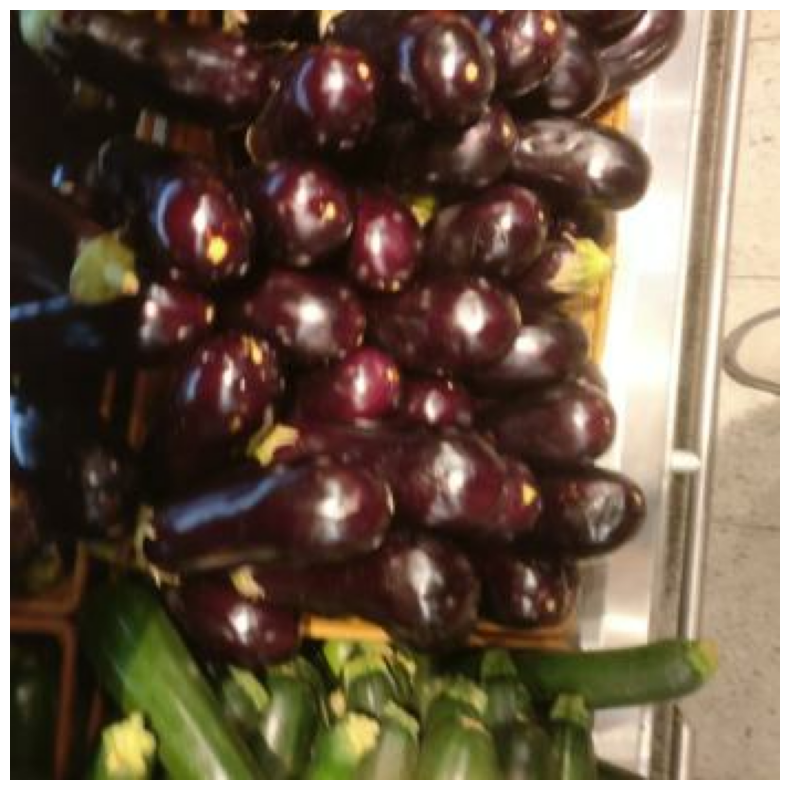

In [22]:
plt.figure(figsize=(10, 10))
# i=21
for images, labels in test.take(10):
    plt.imshow(images[i].numpy().astype("uint8"))
    class_id = np.argmax(labels[i])
    print(class_id, label_pred[i])
    # plt.title(test.class_names[class_id])
    # print(test.class_names[label_pred[i]])
    plt.axis("off")

In [ ]:
num_img = 10
print("\n**** Convolutional Neural Network: \n")
print(np.argmax(cnn_predictions[num_img]*100))
print(cnn_predictions[num_img]*100)
print(np.max(cnn_predictions[num_img]*100), "% de chance")

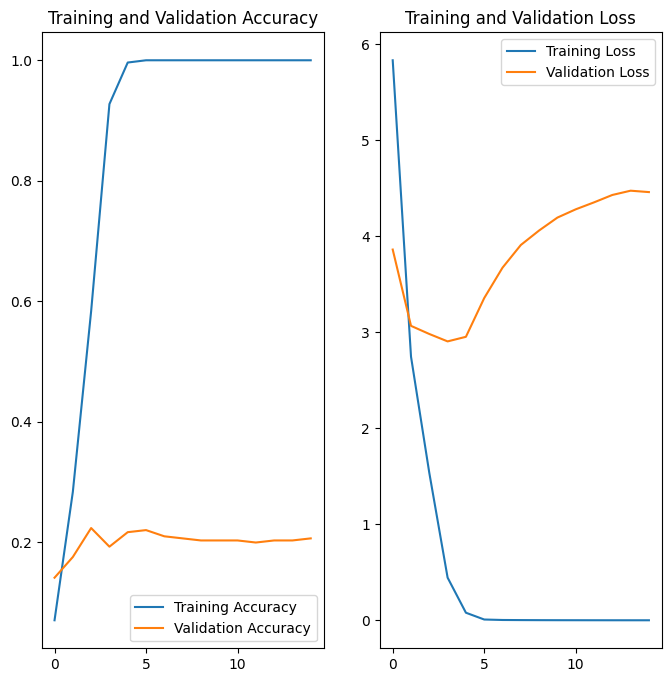

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0,15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()